---
title: "算法交易：制胜策略与原理(欧内斯特·陈)之二"
author: 王一刀
categories: [量化交易]
date: 2024-08-22
format: html
---

我们所说的均值回归并不是指价格的波动，而是指相应收益率通常以均值为零的形式所进行的随机分布。

在本章中，我所描述的测试和交易策略都是根据时间序列型均值回归模式定制的；有另一种均值回归模式，叫作“横断面”型均值回归，横截面型均值回归意味着一篮子的金融工具之累积收益率将恢复至整个篮子的累积收益水平，这也意味着：短期之内，相应金融工具之相对收益率是连续反相关的（一个金融工具的相对收益率是该项目的收益率减去整个组合篮子的收益率）。


(-1.8430182830405568, 0.35932298598891743, 1, 1214, {'1%': -3.4357480073434905, '5%': -2.863923702481129, '10%': -2.568039121778048})
H=0.475844 pValue=0.000000


C:\Users\win10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\win10\AppData\Local\Temp\ipykernel_22572\527508146.py:22: RuntimeWarning: divide by zero encountered in log
  X=np.log(taus)


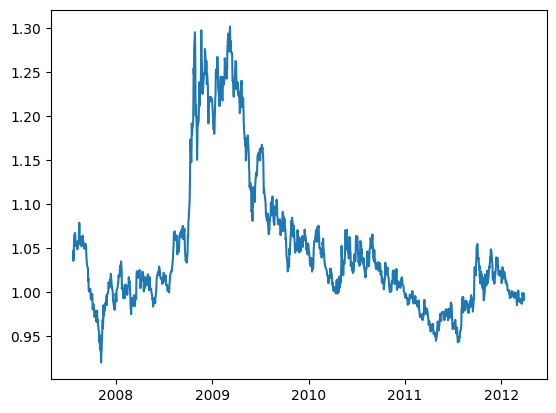

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
# from genhurst import genhurst 

def genhurst(z):
# =============================================================================
# calculation of Hurst exponent given log price series z
# =============================================================================
    z=pd.DataFrame(z)
    # 计算一系列时间延迟 taus，这些时间延迟是时间序列长度的十分之一左右。时间延迟不能与时间序列长度相同，因为这会导致统计不稳定。
    taus=np.arange(np.round(len(z)/10)).astype(int) # We cannot use tau that is of same magnitude of time series length 
    # 初始化一个空数组 logVar，用于存储每个时间延迟对应的对数方差。
    logVar=np.empty(len(taus)) # log variance
    # 对于每个时间延迟 tau，计算 z 的差分序列（即相邻元素之间的差异）的方差，并取对数。将结果存储在 logVar 数组中。
    for tau in taus:
        logVar[tau]=np.log(z.diff(tau).var(ddof=0))

    # 创建两个数组 X 和 Y，分别表示时间延迟的对数和对应的对数方差。 
    X=np.log(taus)    
    Y=logVar[:len(taus)]
    # 删除 logVar 中包含非有限值（如NaN或无穷大）的元素对应的 X 和 Y 中的元素。
    X=X[np.isfinite(logVar)]
    Y=Y[np.isfinite(logVar)]
#    pd.DataFrame(np.asmatrix([X, Y]).T).to_csv('XY.csv')

    X = sm.add_constant(X)
    # plt.scatter(X[:,1], Y) # for debug only
    # 使用 statsmodels 库中的 OLS 函数拟合一个线性回归模型，其中 Y 是因变量，X 是自变量（包括一个常数项）。
    model=sm.OLS(Y, X)
    results=model.fit()
    # 从拟合结果中提取 Hurst 指数 H（即斜率的一半）和相应的 p 值 pVal
    H=results.params[1]/2
    pVal=results.pvalues[1]
    return H, pVal

df=pd.read_csv('datas/inputData_USDCAD.csv')
# print(df)
df.set_index('Date',inplace=True)
y=df.loc[df['Time']==1659, 'Close']
# 将索引转换为matplotlib可识别的日期格式
y.index = pd.to_datetime(y.index,format='%Y%m%d')
# print(y)
plt.plot(y)

# y：要检验的时间序列。
# maxlag：最大滞后阶数，用于构建ADF检验的模型。这里设置为1。
# regression：回归类型。'c'表示在回归模型中包含常数项。
# autolag：自动选择滞后阶数。这里设置为None，表示不自动选择滞后阶数。
results=adfuller(y, maxlag=1, regression='c', autolag=None)
# adfuller 函数是 statsmodels 库中的一个函数，用于执行 Augmented Dickey-Fuller (ADF) 单位根检验
# Test Statistic（检验统计量）：这是用于检验单位根假设的统计量。如果此值小于临界值，则拒绝原假设，认为时间序列是平稳的。
# p-value（p值）：这是检验统计量的概率值。如果 p 值小于预设的显著性水平（通常为 0.05），则拒绝原假设，认为时间序列是平稳的。
# Critical Values（临界值）：这是一组用于与检验统计量进行比较的值。通常有三个临界值，分别对应于 1%、5% 和 10% 的显著性水平。如果检验统计量小于这些临界值，则拒绝原假设。
# Number of Lags Used（使用的滞后阶数）：这是用于 ADF 检验的滞后阶数。滞后阶数的选择会影响检验的结果。
# Number of Observations Used in Regression Analysis（回归分析中使用的观测值数量）：这是用于回归分析的观测值数量。
# Critical Values (1%, 5%, and 10%)（临界值，1%、5% 和 10%）：这是一组用于与检验统计量进行比较的值，分别对应于 1%、5% 和 10% 的显著性水平。
# ADF Statistic（ADF 统计量）：这是 ADF 检验的主要统计量，与 Test Statistic 相同。
# p-value (Adjusted)（调整后的 p 值）：这是调整后的 p 值，考虑了滞后阶数的选择。
print(results)

# Find Hurst exponent
H, pVal=genhurst(np.log(y))
print("H=%f pValue=%f" % (H, pVal))

(-1.8430182830405568, 0.35932298598891743, 1, 1214, {'1%': -3.4357480073434905, '5%': -2.863923702481129, '10%': -2.568039121778048})
这个结果来自ADF单位根检验，以下是对结果的解读：

ADF统计量：-1.8430182830405568  
p值：0.35932298598891743  
使用的滞后阶数：1  
观测值数量：1214  
临界值：{'1%': -3.4357480073434905, '5%': -2.863923702481129, '10%': -2.568039121778048}  
根据ADF单位根检验的结果，我们可以得出以下结论：  

ADF统计量为-1.8430182830405568，小于5%的临界值-2.863923702481129，但大于10%的临界值-2.568039121778048。
p值为0.35932298598891743，大于预设的显著性水平0.05。

**由于ADF统计量大于10%的临界值，且p值大于0.05，我们不能拒绝原假设，即时间序列存在单位根，因此时间序列是非平稳的。**

将回归系数λ和均值回归的半衰期连接在一起对交易者来说非常有用，其原因是：
* 第一，如果我们发现λ是正值，那么就意味着价格系列并不是均值回归的形态，甚至我们不应该试图以均值回归的策略去进行相关交易；
* 第二，如果λ值非常接近于零，这意味着半衰期很长，运用均值回归的交易策略将不会很赚钱，因为我们无法在给在给定的时间范围内完成许多个回合的交易；
* 第三，这个λ也可以为我们交易策略中的许多参数决定一个自然的时间尺度。


In [24]:
df=pd.read_csv('datas/inputData_USDCAD.csv')
# print(df)
df.set_index('Date',inplace=True)
y=df.loc[df['Time']==1659, 'Close']
# 将索引转换为matplotlib可识别的日期格式
y.index = pd.to_datetime(y.index,format='%Y%m%d')
y = y[y.notna().values] #删除包含缺失值的行。
# print(y)
# plt.plot(y)
ylag = y.shift() #创建一个滞后变量
# print(ylag)
deltay = y - ylag #计算收盘价的差分
# print(deltay)
deltay = deltay[1:] #删除第一个NaN值
# print(deltay)

# print(ylag[1:])
X=sm.add_constant(ylag[1:]) # 为滞后变量添加常数项
# print(X)
model=sm.OLS(deltay, X) #创建一个线性回归模型
res=model.fit() #拟合模型
halflife=-np.log(2)/res.params[1] #计算半衰期
print('halflife:',halflife)

halflife: 115.20979448515476


如果我们可以找到一个由几个非平稳的价格系列所构建的平稳的线性组合，那么，这些价格系列则被称之为**协整**形式。

如果我们能结合两个或多个非平稳的价格系列组成平稳的投资组合，那么这些价格系列被称为协整。

协整可以用CADF测试或约翰森测试进行测试。

加强版的ADF检验（CADF）和约翰森检验的模式。前者是只适合一对价格系列，而后者则适用于任何数量的价格系列。

一个特定资产的对冲比率是在投资组合中我们应该做多，或做空多大数量的单位资产——如果资产是股票，那么单位数量所对应的就是股票的股数，而一个负的对冲比率表明我们应该做空此类资产.

首先通过运行两个价格系列之间的线性回归的相关性来确定最优的对冲比率，然后使用这种对冲比率形成相应的投资组合，最后在该组合之内对相应的价格系列进行平稳性的测试

EWA：iShares MSCI Australia ETF，是一种交易所交易基金，旨在追踪澳大利亚股票市场的表现。

EWC：iShares MSCI Canada ETF，同样是一种交易所交易基金，旨在追踪加拿大股票市场的表现。

IGE：一个由自然资源类股票所构成的基金。



Intercept    6.411331
EWA          0.962429
dtype: float64
hedgeRatio=0.962429
t-statistic=-3.063528
pvalue=0.095866
crit_value: [-3.90376106 -3.34020915 -3.04728056]
result.lr1: [19.98321869  3.98276124]
result.cvt: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
result.lr2: [16.00045745  3.98276124]
result.cvm: [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
result.lr1: [34.42862022 17.53171895  4.47102054]
result.cvt: [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
result.lr2: [16.89690127 13.06069841  4.47102054]
result.cvm: [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
result.eig: [0.01121626 0.00868086 0.00298021]
result.evec: [[ 0.7599635  -0.11204898  0.0789828 ]
 [-1.04602749 -0.5796762   0.26467204]
 [ 0.22330592  0.53159644 -0.09515547]]
Intercept   -0.115768
ylag        -0.030586
dtype: float64
halflife=22.662578 days
numUnits:              0
0          NaN
1          NaN
2          NaN
3   

C:\Users\win10\AppData\Local\Temp\ipykernel_15472\4197053767.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedgeRatio=results.params[1]


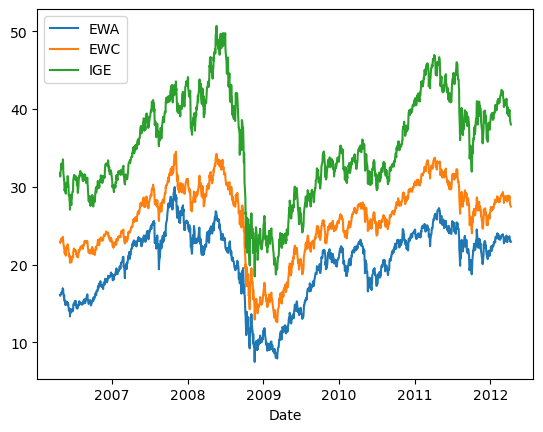

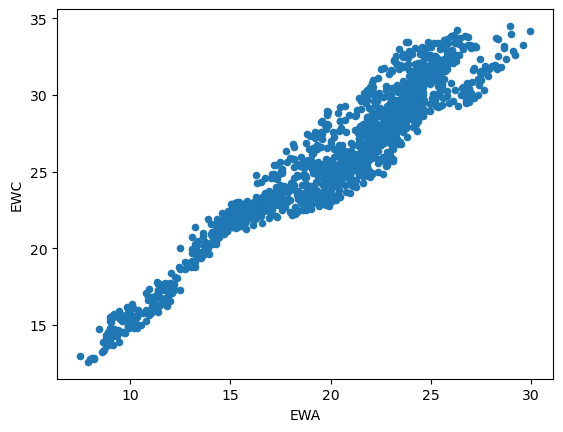

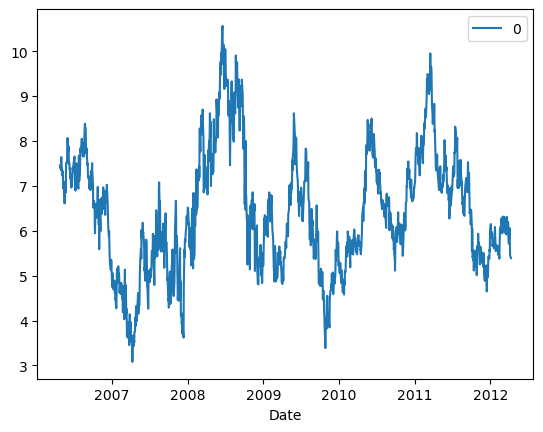

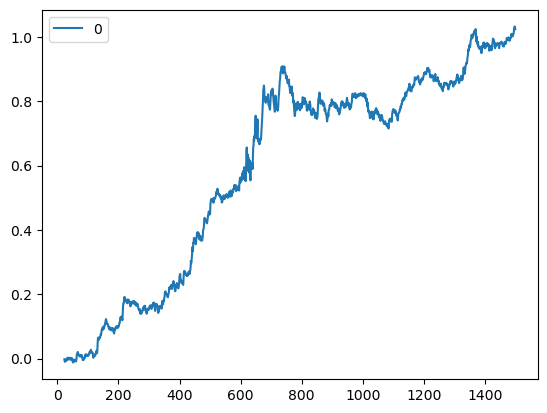

In [21]:
# Using the CADF test for cointegration

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('datas/inputData_EWA_EWC_IGE.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)
# 绘制EWA和EWC的时间序列图
df.plot()
# 绘制EWA和EWC的散点图
df.plot.scatter(x='EWA', y='EWC')
# 使用普通最小二乘法（OLS）拟合EWA和EWC之间的关系
results=sm.ols(formula="EWC ~ EWA", data=df[['EWA', 'EWC']]).fit()
# 这行代码打印出模型的参数，包括截距和斜率
print(results.params)
# 计算对冲比率
hedgeRatio=results.params[1]
print('hedgeRatio=%f' % hedgeRatio)
# 绘制残差图
pd.DataFrame((df['EWC']-hedgeRatio*df['EWA'])).plot()

# cadf test
coint_t, pvalue, crit_value=ts.coint(df['EWA'], df['EWC'])
# coint_t：t统计量，用于检验两个序列是否协整。
# pvalue：p值，用于判断t统计量的显著性。如果p值小于某个显著性水平（如0.05），则拒绝原假设（即两个序列不协整）。
# crit_value：临界值，用于与t统计量进行比较。
print('t-statistic=%f' % coint_t)
print('pvalue=%f' % pvalue)
print('crit_value:',crit_value)

# Johansen test
result=vm.coint_johansen(df[['EWA', 'EWC']].values, det_order=0, k_ar_diff=1)
# result.lr1：第一个特征值的迹统计量。
# result.cvt：第一个特征值的临界值。
# result.lr2：第二个特征值的迹统计量。
# result.cvm：第二个特征值的临界值。
# 约翰森检验的输出结果包括迹统计量和相应的临界值，用于判断多个时间序列之间是否存在协整关系。如果迹统计量大于临界值，则拒绝原假设（即不存在协整关系）。
print(result)
print('result.lr1:',result.lr1)
print('result.cvt:',result.cvt)
print('result.lr2:',result.lr2)
print('result.cvm:',result.cvm)

# Add IGE for Johansen test
result=vm.coint_johansen(df.values, det_order=0, k_ar_diff=1)
print(result)
print('result.lr1:',result.lr1)
print('result.cvt:',result.cvt)
print('result.lr2:',result.lr2)
print('result.cvm:',result.cvm)
# 特征值
print('result.eig:',result.eig) # eigenvalues
# 特征向量
print('result.evec:',result.evec) # eigenvectors

# 计算投资组合的市值   result.evec[:, 0] 是一个NumPy数组操作，它表示从result.evec这个二维数组中取出所有行（用 : 表示）的第0列（用 0 表示）的元素
# np.dot 是 NumPy 库中的一个函数，用于计算两个数组的点积。它可以用于计算两个向量的点积，或者计算一个矩阵与另一个矩阵的乘积。
# 这里的"市值"并不是传统意义上的市值，而是通过主成分分析得到的一个度量值。这个度量值可以帮助我们理解数据的主要变化趋势和结构。
yport=pd.DataFrame(np.dot(df.values, result.evec[:, 0])) #  (net) market value of portfolio
ylag=yport.shift()
deltaY=yport-ylag
df2=pd.concat([ylag, deltaY], axis=1)
df2.columns=['ylag', 'deltaY']
regress_results=sm.ols(formula="deltaY ~ ylag", data=df2).fit() # Note this can deal with NaN in top row
print(regress_results.params)

halflife=-np.log(2)/regress_results.params['ylag']
print('halflife=%f days' % halflife)

#  Apply a simple linear mean reversion strategy to EWA-EWC-IGE
 # 设置回望期为上面找到的半衰期
lookback=np.round(halflife).astype(int) #  setting lookback to the halflife found above
# yport.rolling(lookback).mean() 计算了一个移动平均值，窗口大小为 lookback。这个移动平均值代表了在过去 lookback 个时间点的平均市值。
# yport.rolling(lookback).std() 计算了一个移动标准差，窗口大小为 lookback。这个移动标准差代表了在过去 lookback 个时间点的市值波动程度。
# (yport - yport.rolling(lookback).mean()) 计算了每个时间点的市值与其移动平均值的差值。正值表示市值高于平均值，负值表示市值低于平均值。
# -(yport - yport.rolling(lookback).mean()) / yport.rolling(lookback).std() 计算了每个时间点的单位数量。正值表示买入，负值表示卖出。单位数量的计算公式为：(市值 - 移动平均值) / 移动标准差。这个公式实际上计算了一个标准化后的差值，使得单位数量在不同的时间点和不同的投资组合之间具有可比性。
numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
print('numUnits:',numUnits)
# 计算了基于线性均值回归策略的投资组合的市值分布
# result.evec[:, 0] 是一个一维数组，表示第一个特征向量。这个特征向量是从主成分分析（PCA）或其他类似方法中得到的。
# np.expand_dims(result.evec[:, 0], axis=1).T 将一维数组转换为二维数组，并进行转置。这样做的目的是为了使其能够与 numUnits.values 相乘。
# np.dot(numUnits.values, np.expand_dims(result.evec[:, 0], axis=1).T) 计算单位数量与特征向量的点积。这个点积表示每个投资组合单位在第一个特征向量方向上的投影。
# np.dot(numUnits.values, np.expand_dims(result.evec[:, 0], axis=1).T) * df.values 将点积结果与原始数据相乘，得到每个投资组合单位在每个资产上的市值。
positions=pd.DataFrame(np.dot(numUnits.values, np.expand_dims(result.evec[:, 0], axis=1).T)*df.values) # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
print('positions:',positions)
print('np.expand_dims(result.evec[:, 0], axis=1).T : ',np.expand_dims(result.evec[:, 0], axis=1).T)
print('np.dot(numUnits.values, np.expand_dims(result.evec[:, 0], axis=1).T):',np.dot(numUnits.values, np.expand_dims(result.evec[:, 0], axis=1).T))
# 计算了基于线性均值回归策略的投资组合的每日收益（P&L）
# positions.shift().values：将 positions DataFrame 向前移动一个时间点，得到前一天的投资组合市值。
# df.pct_change().values：计算原始数据（df）的每日百分比变化。
# (positions.shift().values)*(df.pct_change().values)：将前一天的投资组合市值与每日百分比变化相乘，得到每日收益。
# np.sum((positions.shift().values)*(df.pct_change().values), axis=1)：沿着列方向（axis=1）求和，得到每个时间点的总收益。
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
# pnl：上一行代码计算出的每日收益。
# np.sum(np.abs(positions.shift()), axis=1)：计算前一天的投资组合市值的绝对值之和。
# ret = pnl / np.sum(np.abs(positions.shift()), axis=1)：将每日收益除以前一天的投资组合市值的绝对值之和，得到每日收益率。
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
# np.cumprod(1+ret)：计算每日收益率的累积乘积，得到累计收益率。
# np.cumprod(1+ret)-1：将累计收益率减去1，得到累计收益。
pd.DataFrame((np.cumprod(1+ret)-1)).plot()
print('============')
print('np.prod(1+ret):',np.prod(1+ret))
print('252/len(ret):',252/len(ret))
# np.prod() 是 NumPy 库中的一个函数，用于计算数组中所有元素的乘积。这个函数可以用于计算一组数值的乘积，例如计算一组收益率的乘积以得到累积收益率。
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
# APR=0.125739 Sharpe=1.391310

在约翰森检测结果中，我们应该期待第一协整关系是“最强”的，也就是说，相应均值回归的半衰期最短，进而使我们很自然地选择这个特征向量形成平稳的投资组合（特征向量可以确定ETF基金内各类资产的权重），同时，我们可以用与之前相同的方法发现其半衰期，并应对一个平稳的价格系列。

均值回归之配对交易的背后通常都有一个基本的原理：为什么EWA基金要和EWC基金之间进行协整呢？这是因为加拿大和澳大利亚的经济中，占主导地位的是大宗商品交易。那么，股票指数型基金GDX为什么要和黄金GLD协整呢？这是因为金矿公司的市值是基于黄金价值的。即使一对协整关系破裂（停止协整），我们通常都要对其分崩离析的原因进行解析。例如，在第4章的分析中，我们发现GDX基金和黄金GLD的协整关系在2008年年初便处于解体的状态，而能源价格的高腾导致黄金的开采异常昂贵。

交易策略相关的另一个极端情境是：依赖于基本面分析的投资者偏好于投资那些被低估并持有很多年的股票，耐心地等待它们的价格回归至“正常”的价值水平。  
短时间内完成交易对我们这一类交易者最有利，因为较短的时间尺度意味着每年有更高的交易数量，进而使我们的回测系统与实时交易具有更高的统计信心和更高的夏普比率，最终使我们的交易策略具有更高的复合收益率。

看似具有很高一致性的均值回归的交易策略最终可能会失效。迈克尔·德弗指出，这种高度一致性经常会使相关的交易员过度自信，且过度举债（德弗，2011）（考虑一下长期的资本管理问题）。当均值回归交易策略突然崩坏，其原因也许是我们都是“事后诸葛亮”，而且，此类事件经常发生在我们以此策略获得一系列成功之后、加大交易杠杆之时，由此而产生的罕见的损失往往是非常痛苦的，有时是灾难性的。因此，所谓的风险管理的概念对均值回归型的交易者尤为重要，但也特别困难，因为通常意义上的止损是不能按逻辑进行部署的。



特征值： [0.01121626 0.00868086 0.00298021]
特征向量： [[ 0.7599635  -0.11204898  0.0789828 ]
 [-1.04602749 -0.5796762   0.26467204]
 [ 0.22330592  0.53159644 -0.09515547]]
迹统计量： [34.42862022 17.53171895  4.47102054]
迹统计量的临界值： [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
最大特征值统计量： [16.89690127 13.06069841  4.47102054]
最大特征值统计量的临界值： [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
[27.0669 13.4294  2.7055]
result.lr1 > result.cvt[:, 0]: [ True  True  True]
np.any(result.lr1 > result.cvt[:, 0]): True
result.evec[:, 0]: [ 0.7599635  -1.04602749  0.22330592]
Intercept   -0.115768
ylag        -0.030586
dtype: float64
halflife=22.662578 days
组合初始值: 100000000.0
__init__ 23 [ 0.7599635  -1.04602749  0.22330592]
__init__ 1500
__init__ 1500
__init__ 1500
__init__ 1500
<class 'numpy.ndarray'>
Mean: 0
Std Dev: 0
组合终结值: nan
result: <__main__.TestStrategy object at 0x000001E40E83B5B0>
--------------- AnnualReturn -----------------
OrderedD

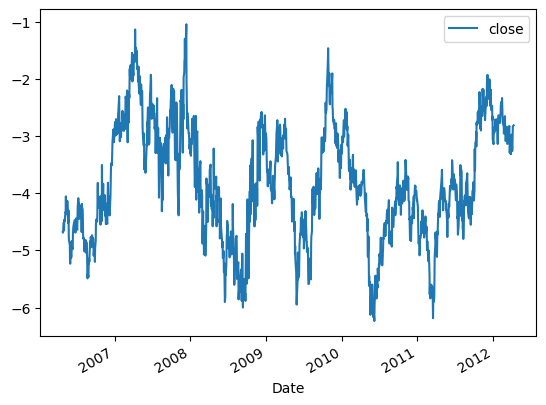

In [34]:
import datetime
import numpy as np
import pandas as pd
import backtrader as bt
import statsmodels.tsa.vector_ar.vecm as vm
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
# 读取CSV文件
data_df = pd.read_csv('datas/inputData_EWA_EWC_IGE.csv')

# 将日期列转换为datetime类型
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%Y%m%d')
data_df.set_index('Date', inplace=True)

result=vm.coint_johansen(data_df.values, det_order=0, k_ar_diff=1)
print("特征值：", result.eig)
print("特征向量：", result.evec)
print("迹统计量：", result.lr1)
print("迹统计量的临界值：", result.cvt)
print("最大特征值统计量：", result.lr2)
print("最大特征值统计量的临界值：", result.cvm)

print(result.cvt[:, 0])
print('result.lr1 > result.cvt[:, 0]:',result.lr1 > result.cvt[:, 0])
print('np.any(result.lr1 > result.cvt[:, 0]):',np.any(result.lr1 > result.cvt[:, 0]))

# 二维三列矩阵和特征向量相乘  即每种产品价格和占比相乘后相加 得到总市值
print('result.evec[:, 0]:',result.evec[:, 0])
yport=pd.DataFrame(np.dot(data_df.values, result.evec[:, 0]),columns=['close']) 
# print(yport) 算出的值都是负值，整体上是空头，基本没法玩
ylag=yport.shift()
deltaY=yport-ylag
df2=pd.concat([ylag, deltaY], axis=1)
df2.columns=['ylag', 'deltaY']
regress_results=sm.ols(formula="deltaY ~ ylag", data=df2).fit() # Note this can deal with NaN in top row
print(regress_results.params)

halflife=-np.log(2)/regress_results.params['ylag']
print('halflife=%f days' % halflife)
lookback=np.round(halflife).astype(int)
numUnits =-(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std() 
# print(numUnits)
# 为yport增加索引列
yport.index = data_df.index

yport.plot()
# print(yport.iloc[0])
# data_df = data_df.reset_index()
data_EWA_new = data_df[['EWA']].rename(columns={'EWA':'close'})
data_EWC_new = data_df[['EWC']].rename(columns={'EWC':'close'})
data_IGE_new = data_df[['IGE']].rename(columns={'IGE':'close'})

# print('data_EWA_new:',data_EWA_new)
# 创建PandasData对象
data_EWA = bt.feeds.PandasData(dataname=data_EWA_new)
data_EWC = bt.feeds.PandasData(dataname=data_EWC_new)
data_IGE = bt.feeds.PandasData(dataname=data_IGE_new)


class TestStrategy(bt.Strategy):
    def __init__(self, lookback, proportion ):
        self.lookback = lookback
        self.proportion  = proportion 
        self.ctg_price = self.datas[0].close
        self.EWA = self.datas[1].close
        self.EWC = self.datas[2].close
        self.IGE = self.datas[3].close
        print('__init__', lookback, proportion)
        print('__init__',self.datas[0].buflen())
        print('__init__',self.datas[1].buflen())
        print('__init__',self.datas[2].buflen())
        print('__init__',self.datas[3].buflen())
        # print('__init__',self.datas[0].close[0])
        print(type(self.proportion))
        # 创建一个滚动窗口均值指标  Add a MovingAverageSimple indicator
        self.mean = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.lookback)
        # 创建一个滚动窗口标准差指标  
        self.std = bt.indicators.StandardDeviation(self.datas[0], period=self.lookback)
        # 使用上面的指标计算标准化差异
        # self.zscore = -(self.datas[0] - self.mean) / self.std
        # self.zscore = bt.indicators.ZScore(self.datas[0].close, period=self.params.lookback)
        print("Mean:", self.mean.buflen())  # 注意：索引 0 可能在第一个数据点上不可用  此时均值并没有计算，只有在next中才会实时计算
        print("Std Dev:", self.std.buflen())  
        # print("Z-Score:", self.zscore.buflen())  

    def next(self):
        # 在这里编写你的策略逻辑
        # 你可以使用 self.param1 和 self.param2 访问传递的参数
        # print(self.data.datetime.date(0))
        # print(self.datas[0].close[0])
        # print('price:',self.data.close[0])
        # print('price:',self.ctg_price[0])
        # print('EWA price:',self.EWA[0])
        # print('EWC price:',self.EWC[0])
        # print('IGE price:',self.IGE[0])
        # print(self.ctg_price[0])
         # 检查是否有足够的数据点来计算均值和标准差  
        if len(self.mean) > 0 and len(self.std) > 0:  
            # 计算当前的 Z-score  
            # 注意：我们需要确保标准差不为0（虽然在实际金融数据中这很少见）  
            if self.std[0] != 0:  
                z = -(self.ctg_price[0] - self.mean[0]) / self.std[0]  # 这个买入还是卖出问题还没闹清楚
                self.zscore = z  # 存储 Z-score 值以便后续使用（如果需要的话）
                # print('zscore:',self.zscore)
                positions = self.zscore*self.proportion
                # print('positions:',positions)
                # 这里计算权重的方法并不确定
                w1 = (positions[0]/np.abs(positions).sum()).round(2)
                w2 = (positions[1]/np.abs(positions).sum()).round(2)
                w3 = (positions[2]/np.abs(positions).sum()).round(2)
                # print('w1:',w1)
                # print('w2:',w2)
                # print('w3:',w3)
                if self.zscore > 0:  # 买入
                    # print("卖出！ Current Z-Score:", z)
                    # print('比例：',self.proportion)
                    # self.sell(data=self.datas[0],size=1000)
                    if w1 > 0:
                        self.buy(data=self.datas[1],size=1000*w1)
                    else:
                        self.sell(data=self.datas[1],size=1000*np.abs(w1))
                    if w2 > 0:
                        self.buy(data=self.datas[2],size=1000*w2)
                    else:
                        self.sell(data=self.datas[2],size=1000*np.abs(w2))
                    if w3 > 0:
                        self.buy(data=self.datas[3],size=1000*w3)
                    else:
                        self.sell(data=self.datas[3],size=1000*np.abs(w3))
                    # print(self.sell())
                elif self.zscore < 0: # 卖出
                    # print("买入！ Current Z-Score:", z)
                    # print('比例：',self.proportion)
                    # self.buy(data=self.datas[0],size=1000)
                    # print(self.buy())
                    if w1 > 0:
                        self.sell(data=self.datas[1],size=1000*w1)
                    else:
                        self.buy(data=self.datas[1],size=1000*np.abs(w1))
                    if w2 > 0:
                        self.sell(data=self.datas[2],size=1000*w2)
                    else:
                        self.buy(data=self.datas[2],size=1000*np.abs(w2))
                    if w3 > 0:
                        self.sell(data=self.datas[3],size=1000*w3)
                    else:
                        self.buy(data=self.datas[3],size=1000*np.abs(w3))
            else:  
                print("Standard deviation is zero, cannot calculate Z-Score.")

# 创建 cerebro 实例
cerebro = bt.Cerebro()
# 初始资金 100,000,000
cerebro.broker.setcash(100000000.0)
# 佣金，双边各 0.0003
cerebro.broker.setcommission(commission=0.0003)
# 滑点：双边各 0.0001
cerebro.broker.set_slippage_perc(perc=0.0001)
# 这里有点问题，并没有得出分析结果
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='pnl') # 返回收益率时序数据
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn') # 年化收益率
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio') # 夏普比率
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown') # 回撤

cerebro.addstrategy(TestStrategy, lookback=lookback, proportion=result.evec[:, 0])
# 保存6位小数，解决策略中小数点位数边长的问题
yport['close'] = yport['close'].round(6)
# data_price =  bt.feeds.PandasData(dataname=yport, fromdate=datetime.datetime(2006, 4, 26), todate=datetime.datetime(2006, 4, 30))
data_price =  bt.feeds.PandasData(dataname=yport)
cerebro.adddata(data_price)
cerebro.adddata(data_EWA)
cerebro.adddata(data_EWC)
cerebro.adddata(data_IGE)
print("组合初始值:",cerebro.broker.getvalue())
result = cerebro.run()
print("组合终结值:",cerebro.broker.getvalue())
print('result:',result[0])
strat = result[0]
# 返回日度收益率序列
daily_return = pd.Series(strat.analyzers.pnl.get_analysis())
# 打印评价指标
print("--------------- AnnualReturn -----------------")
print(strat.analyzers._AnnualReturn.get_analysis())
print("--------------- SharpeRatio -----------------")
print(strat.analyzers._SharpeRatio.get_analysis())
print("--------------- DrawDown -----------------")
print(strat.analyzers._DrawDown.get_analysis())